In [ ]:
# connect to database at sqlite:///ipeds_data.db
import sqlite3
import pandas as pd
import os
import sys

# check if the database file exists
db_file = 'ipeds_data.db'
if not os.path.exists(db_file):
    print(f"Database file '{db_file}' does not exist.")
    sys.exit(1)


# connect to the database
conn = sqlite3.connect(db_file)
# create a cursor
cursor = conn.cursor()

In [ ]:


query = """
WITH CTE AS (
    SELECT
        enrl.unit_id
        ,inst.institution_name
        ,inst.state
        ,enrl.num_first_time_freshmen
        ,RANK() OVER (PARTITION BY inst.state ORDER BY enrl.num_first_time_freshmen DESC) AS rank
    FROM 
        enrollment enrl
        LEFT JOIN institution inst
        ON enrl.unit_id = inst.unit_id
)
SELECT *
FROM CTE 
WHERE rank = 1
;
"""

# run query
df = pd.read_sql_query(query, conn)
df.head()

,unit_id,institution_name,state,num_first_time_freshmen,rank
0,102553,University of Alaska Anchorage,AK,1306,1
1,100751,The University of Alabama,AL,8279,1
2,106397,University of Arkansas,AR,6337,1
3,104151,Arizona State University Campus Immersion,AZ,14102,1
4,110565,California State University-Fullerton,CA,7070,1


In [4]:
# question: what were the most selective institutions
query = """
SELECT
    inst.unit_id
    ,inst.institution_name
    ,adm.num_applicants
    ,adm.num_admissions
    ,adm.num_admissions / adm.num_applicants AS adm_rate
FROM 
    institution inst 
LEFT JOIN admissions adm
ON inst.unit_id = adm.unit_id
WHERE adm.num_applicants > 1000
ORDER BY adm_rate 
LIMIT 100
;
"""

df = pd.read_sql_query(query, conn)
df.head()


,unit_id,institution_name,num_applicants,num_admissions,adm_rate
0,110404,California Institute of Technology,13107,412.0,0.031434
1,166027,Harvard University,56937,1965.0,0.034512
2,484844,Minerva University,9856,350.0,0.035511
3,190008,Circle in the Square Theatre School,1114,42.0,0.037702
4,243744,Stanford University,53733,2099.0,0.039064


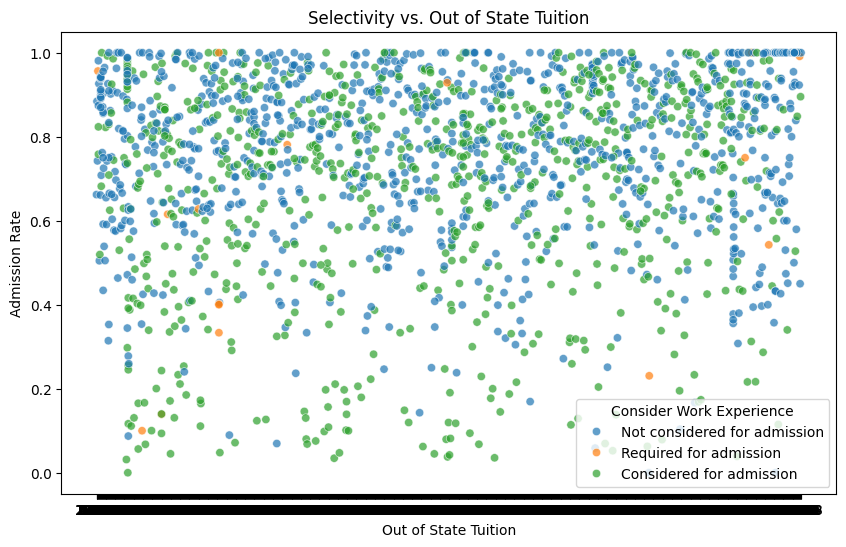

In [10]:
# visualization: charge and selectivity with color as considering workstudy
query = """
SELECT
    chrg.unit_id
    ,chrg.out_of_state_tuition
    ,adm.num_admissions / adm.num_applicants AS adm_rate
    ,adm.consider_work_exp
FROM student_charges        chrg
LEFT JOIN admissions        adm
    ON chrg.unit_id = adm.unit_id
"""

df = pd.read_sql_query(query, conn)

# remove null values
df = df.dropna()
df.head()

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='out_of_state_tuition', y='adm_rate', hue='consider_work_exp', alpha=0.7)
plt.title('Selectivity vs. Out of State Tuition')
plt.xlabel('Out of State Tuition')
plt.ylabel('Admission Rate')
plt.legend(title='Consider Work Experience')
plt.show()


